In [1]:
import sys, os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))

from src.utils.utils import extract_roi, get_fo_features

# Testes de processamento de imagens

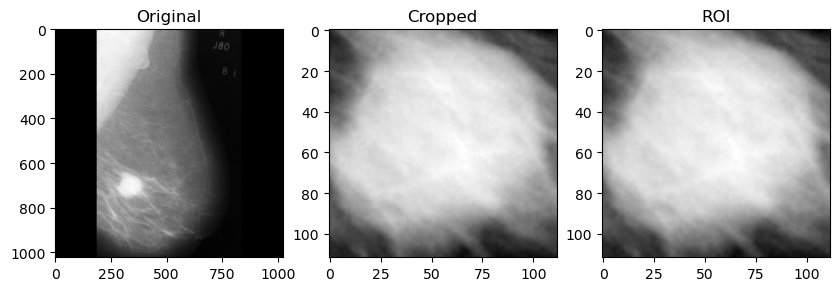

In [2]:
df = pd.read_csv("../../outputs/mamografia/mias/metadata_mias.csv")

idx = 28
df_one = df.iloc[idx]

radius = int(df_one["radius"])
x, y = df_one["x_center_abnormality"], df_one["y_center_abnormality"]
x, y = int(x), (1024 - int(y))
radius_factor = int(radius * 1.5)

image = cv2.imread(df.iloc[idx]["image_path"], cv2.IMREAD_GRAYSCALE)
cropp1 = cv2.imread(df.iloc[idx]["cropped_image_path"], cv2.IMREAD_GRAYSCALE)
#cropp = image[y - radius_factor: y + radius_factor, x - radius_factor: x + radius_factor]
cropp = cv2.getRectSubPix(image, (2 * radius, 2 * radius), (x, y))
roi = cv2.imread(df.iloc[idx]["roi_image_path"], cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original")

axs[1].imshow(cropp, cmap="gray")
axs[1].set_title("Cropped")

axs[2].imshow(cropp1, cmap="gray")
axs[2].set_title("ROI")

plt.show()

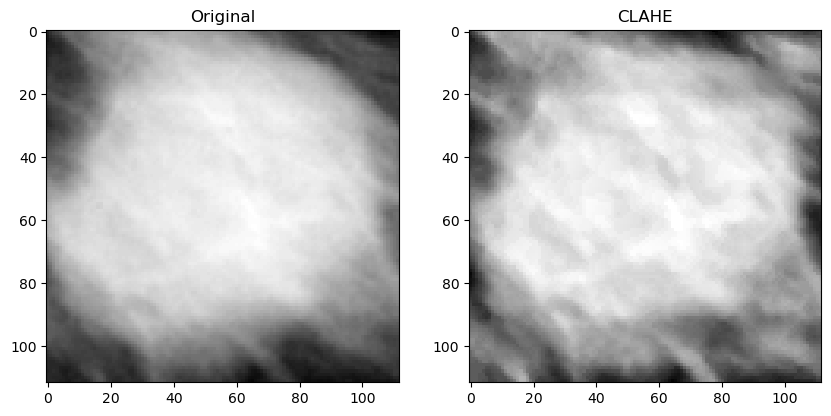

In [3]:
median_cropp = cv2.medianBlur(cropp, 3)
clahe_image = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8)).apply(median_cropp)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cropp, cmap="gray")
axs[0].set_title("Original")

axs[1].imshow(clahe_image, cmap="gray")
axs[1].set_title("CLAHE")

plt.show()